<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predicting West Nile Virus in Mosquitoes

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import datetime
import random
import pickle
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib import dates, cm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic

pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None  # default='warn'

# Read in data files

In [2]:
test = pd.read_csv('../assets/test.csv/test.csv')
test.head(2)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [3]:
spray = pd.read_csv('../assets/processed_data/spray_processed.csv')
spray['lat_long'] = list(zip(spray['Latitude'], spray['Longitude'])) # to compute distances later
spray.head()

,Latitude,Longitude,lat_long
0,41.981433,-87.787777,"(41.9814333333333, -87.7877766666667)"
1,41.980998,-87.787778,"(41.9809983333333, -87.7877783333333)"
2,41.980560,-87.787762,"(41.98056, -87.7877616666667)"
3,41.980198,-87.787758,"(41.9801983333333, -87.7877583333333)"
4,41.979752,-87.787765,"(41.9797516666667, -87.787765)"


In [4]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14199 entries, 0 to 14198
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   14199 non-null  float64
 1   Longitude  14199 non-null  float64
 2   lat_long   14199 non-null  object 
dtypes: float64(2), object(1)
memory usage: 332.9+ KB


In [5]:
weather = pd.read_csv('../assets/processed_data/weather_processed.csv')
weather['Date'] = pd.to_datetime(weather['Date'])
weather.head()

,Date,Tavg,DewPoint,WetBulb,PrecipTotal,AvgSpeed
0,2007-05-01,67.50,51.0,56.5,0.0,9.40
1,2007-05-02,51.50,42.0,47.0,0.0,13.40
2,2007-05-03,57.00,40.0,49.0,0.0,12.55
3,2007-05-04,61.25,41.5,50.0,0.0,10.60
4,2007-05-05,60.00,38.5,49.5,0.0,11.75


In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1472 non-null   datetime64[ns]
 1   Tavg         1472 non-null   float64       
 2   DewPoint     1472 non-null   float64       
 3   WetBulb      1472 non-null   float64       
 4   PrecipTotal  1472 non-null   float64       
 5   AvgSpeed     1472 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 69.1 KB


In [7]:
wnv_density = pd.read_csv('../assets/processed_data/wnv_density_processed.csv')
wnv_density.columns = ['year', 'Address', 'wnv_density']
wnv_density.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         343 non-null    int64 
 1   Address      343 non-null    object
 2   wnv_density  343 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.2+ KB


In [8]:
ada_final = pickle.load(open('../models/adaboost_tuned.sav', 'rb'))

In [9]:
X_train = pd.read_csv('../assets/processed_data/X_train_processed.csv')

In [10]:
# Fit the on the same training data as during Modeling to get the same weights. This will be used to transform the test dataset

ct = ColumnTransformer(
        [("stdscaler", StandardScaler(), ['wnv_density', 'avg_temp', 'tot_precip', 'avg_windspeed'])], remainder='passthrough')

X_train = ct.fit_transform(X_train)

# Engineer Features

In [11]:
test['Date'] = pd.to_datetime(test['Date'])
test['month'] = test['Date'].dt.month
test['year'] = test['Date'].dt.year - 1 # preceding year

In [12]:
# Merge in wnv density data on year and trap address
test_wnv = test.merge(wnv_density, how='left', left_on = ['year', 'Address'], right_on = ['year', 'Address'])
test_wnv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  month                   116293 non-null  int64         
 12  year                    116293

In [13]:
test_wnv.fillna(0, inplace=True) # fill with 0 for those rows with no match

In [14]:
# define function to check whether two lat-long coordinates are within 50 metres. Output 1 if so, else 0

def check_within_50m(coord):
    
    for spray_coord in spray['lat_long']:
        if geodesic(coord, spray_coord).meters <= 50:
            return 1
    return 0

In [15]:
# To reduce computing time, we first take all distinct lat-long combinations to compute distances, since there are many repeat locations in the train dataset

test_latlong = test[['Latitude', 'Longitude']].drop_duplicates(subset=['Latitude', 'Longitude']).reset_index(drop=True)
test_latlong['lat_long'] = list(zip(test_latlong['Latitude'], test_latlong['Longitude']))

In [16]:
test_latlong.head(1)

,Latitude,Longitude,lat_long
0,41.95469,-87.800991,"(41.95469, -87.800991)"


In [17]:
# Takes awhile to run
test_latlong['spray_indicator'] = test_latlong['lat_long'].apply(check_within_50m)

In [18]:
test_latlong.spray_indicator.value_counts()

0    130
1     21
Name: spray_indicator, dtype: int64

In [19]:
test_wnv_spray = test_wnv.merge(test_latlong, how='left', left_on = ['Latitude', 'Longitude'], right_on = ['Latitude', 'Longitude'])
test_wnv_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  month                   116293 non-null  int64         
 12  year                    116293

In [20]:
def get_weather(ls_date):
    '''
    This function takes in a list of dates and returns the preceding 30-day averages of 5 weather indicators: temperature, dew point, wetbulb,
    precipitation (total instead of average), wind speed.
    
    Returns one list for each indicator.
    '''
    temp_list = []
    dewpt_list = []
    wetbulb_list = []
    precip_list = []
    windspeed_list = []
    
    for date in ls_date:
        date = pd.to_datetime(date)
        weather_subset = weather[(weather['Date'] <= date + pd.Timedelta(days=-1)) & (weather['Date'] >= date + pd.Timedelta(days=-31))]
        
        temp_list.append(weather_subset['Tavg'].mean())
        dewpt_list.append(weather_subset['DewPoint'].mean())
        wetbulb_list.append(weather_subset['WetBulb'].mean())
        precip_list.append(weather_subset['PrecipTotal'].sum())
        windspeed_list.append(weather_subset['AvgSpeed'].mean())

    return temp_list, dewpt_list, wetbulb_list, precip_list, windspeed_list

In [21]:
avg_temp, avg_dewpt, avg_wetbulb, tot_precip, avg_windspeed = get_weather(test_wnv_spray['Date'])

In [22]:
test_wnv_spray['avg_temp'] = avg_temp
test_wnv_spray['avg_dewpt'] = avg_dewpt
test_wnv_spray['avg_wetbulb'] = avg_wetbulb
test_wnv_spray['tot_precip'] = tot_precip
test_wnv_spray['avg_windspeed'] = avg_windspeed

In [23]:
test_wnv_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
 11  month                   116293 non-null  int64         
 12  year                    116293

In [24]:
test_wnv_spray.head(3)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,month,year,wnv_density,lat_long,spray_indicator,avg_temp,avg_dewpt,avg_wetbulb,tot_precip,avg_windspeed
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2007,8.0,"(41.95469, -87.800991)",0,61.064516,48.387097,54.596774,4.97,10.340323
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2007,8.0,"(41.95469, -87.800991)",0,61.064516,48.387097,54.596774,4.97,10.340323
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2007,8.0,"(41.95469, -87.800991)",0,61.064516,48.387097,54.596774,4.97,10.340323


In [25]:
# Retain final variables

test_final = test_wnv_spray[['Id', 'Species', 'month', 'wnv_density', 'avg_temp', 'avg_dewpt', 'avg_wetbulb', 
       'tot_precip', 'avg_windspeed', 'spray_indicator']]
test_final.shape

(116293, 10)

In [26]:
test_final.head()

,Id,Species,month,wnv_density,avg_temp,avg_dewpt,avg_wetbulb,tot_precip,avg_windspeed,spray_indicator
0,1,CULEX PIPIENS/RESTUANS,6,8.0,61.064516,48.387097,54.596774,4.97,10.340323,0
1,2,CULEX RESTUANS,6,8.0,61.064516,48.387097,54.596774,4.97,10.340323,0
2,3,CULEX PIPIENS,6,8.0,61.064516,48.387097,54.596774,4.97,10.340323,0
3,4,CULEX SALINARIUS,6,8.0,61.064516,48.387097,54.596774,4.97,10.340323,0
4,5,CULEX TERRITANS,6,8.0,61.064516,48.387097,54.596774,4.97,10.340323,0


# One hot encoding

In [27]:
test_final = pd.get_dummies(test_final, columns=['Species', 'month'])
print(test_final.shape)
test_final.head()

(116293, 21)


,Id,wnv_density,avg_temp,avg_dewpt,avg_wetbulb,tot_precip,avg_windspeed,spray_indicator,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX,month_6,month_7,month_8,month_9,month_10
0,1,8.0,61.064516,48.387097,54.596774,4.97,10.340323,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,2,8.0,61.064516,48.387097,54.596774,4.97,10.340323,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,3,8.0,61.064516,48.387097,54.596774,4.97,10.340323,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,4,8.0,61.064516,48.387097,54.596774,4.97,10.340323,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,5,8.0,61.064516,48.387097,54.596774,4.97,10.340323,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [28]:
test_final.drop(columns=['avg_dewpt', 'avg_wetbulb', 'Species_UNSPECIFIED CULEX'], inplace=True)
print(test_final.shape)

(116293, 18)


In [29]:
# Scale features

test_final_transformed = ct.transform(test_final.drop(columns=['Id']))

In [30]:
test_final_transformed = pd.DataFrame(data=test_final_transformed, index=np.arange(len(test_final_transformed)), columns = ['wnv_density', 'avg_temp', 'tot_precip',
       'avg_windspeed', 'spray_indicator', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10'])

In [31]:
test_final_transformed = test_final[['Id']].join(test_final_transformed)

# Make predictions

In [32]:
test_final_transformed['WnvPresent'] = ada_final.predict_proba(test_final_transformed.drop(columns=['Id']))[:,1]

In [33]:
test_final_transformed.head()

,Id,wnv_density,avg_temp,tot_precip,avg_windspeed,spray_indicator,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,month_6,month_7,month_8,month_9,month_10,WnvPresent
0,1,0.334187,-2.641765,0.313481,3.056656,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.120925
1,2,0.334187,-2.641765,0.313481,3.056656,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.102254
2,3,0.334187,-2.641765,0.313481,3.056656,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.125855
3,4,0.334187,-2.641765,0.313481,3.056656,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.094888
4,5,0.334187,-2.641765,0.313481,3.056656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.083071


In [34]:
test_final_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Id                              116293 non-null  int64  
 1   wnv_density                     116293 non-null  float64
 2   avg_temp                        116293 non-null  float64
 3   tot_precip                      116293 non-null  float64
 4   avg_windspeed                   116293 non-null  float64
 5   spray_indicator                 116293 non-null  float64
 6   Species_CULEX ERRATICUS         116293 non-null  float64
 7   Species_CULEX PIPIENS           116293 non-null  float64
 8   Species_CULEX PIPIENS/RESTUANS  116293 non-null  float64
 9   Species_CULEX RESTUANS          116293 non-null  float64
 10  Species_CULEX SALINARIUS        116293 non-null  float64
 11  Species_CULEX TARSALIS          116293 non-null  float64
 12  Species_CULEX TE

# Output predictions to CSV

In [35]:
test_final_transformed[['Id', 'WnvPresent']].to_csv('../assets/predictions/submission.csv', index=False)

# Where should we spray?

In [36]:
street_map = gpd.read_file('../assets/geo_export_a6957f22-b168-4cee-b03c-0bcc9815308c.shp')

geometry = [Point(xy) for xy in zip(test['Longitude'], test['Latitude'])]

geo_test = gpd.GeoDataFrame(test,
                            crs={'init': 'epsg:4326'},
                             geometry=geometry)

geo_test['WnvPresent'] = test_final_transformed['WnvPresent']
geo_test['WnvPresent'] = geo_test['WnvPresent'].apply(lambda x: 1 if x >= 0.5 else 0)

C:\HA\Python\Anaconda\envs\geoenv\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [37]:
geo_test.head(1)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,month,year,geometry,WnvPresent
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,6,2007,POINT (-87.80099 41.95469),0


In [38]:
# create 1 dataframe, 1 for each year
geo_test_groupby_2008_WNV = geo_test[geo_test['Date'].dt.year==2008].dissolve(by='Address', aggfunc='sum')
geo_test_groupby_2008_WNV = geo_test_groupby_2008_WNV[geo_test_groupby_2008_WNV['WnvPresent'] > 0]

geo_test_groupby_2010_WNV = geo_test[geo_test['Date'].dt.year==2010].dissolve(by='Address', aggfunc='sum')
geo_test_groupby_2010_WNV = geo_test_groupby_2010_WNV[geo_test_groupby_2010_WNV['WnvPresent'] > 0]

geo_test_groupby_2012_WNV = geo_test[geo_test['Date'].dt.year==2012].dissolve(by='Address', aggfunc='sum')
geo_test_groupby_2012_WNV = geo_test_groupby_2012_WNV[geo_test_groupby_2012_WNV['WnvPresent'] > 0]

geo_test_groupby_2014_WNV = geo_test[geo_test['Date'].dt.year==2014].dissolve(by='Address', aggfunc='sum')
geo_test_groupby_2014_WNV = geo_test_groupby_2014_WNV[geo_test_groupby_2014_WNV['WnvPresent'] > 0]

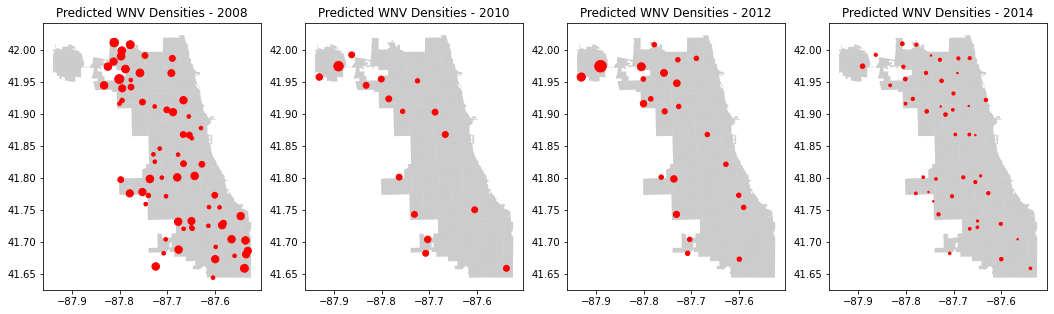

In [39]:
fig,ax = plt.subplots(figsize=(18,18), nrows=1, ncols=4)
street_map.plot(ax=ax[0], alpha=0.4, color='grey')
street_map.plot(ax=ax[1], alpha=0.4, color='grey')
street_map.plot(ax=ax[2], alpha=0.4, color='grey')
street_map.plot(ax=ax[3], alpha=0.4, color='grey')

geo_test_groupby_2008_WNV.plot(ax=ax[0], markersize=(geo_test_groupby_2008_WNV['WnvPresent']).values, color='red', marker='o')
ax[0].set_title('Predicted WNV Densities - 2008')

geo_test_groupby_2010_WNV.plot(ax=ax[1], markersize=(geo_test_groupby_2010_WNV['WnvPresent']).values, color='red', marker='o')
ax[1].set_title('Predicted WNV Densities - 2010')

geo_test_groupby_2012_WNV.plot(ax=ax[2], markersize=(geo_test_groupby_2012_WNV['WnvPresent']).values, color='red', marker='o')
ax[2].set_title('Predicted WNV Densities - 2012')

geo_test_groupby_2014_WNV.plot(ax=ax[3], markersize=(geo_test_groupby_2014_WNV['WnvPresent']).values, color='red', marker='o')
ax[3].set_title('Predicted WNV Densities - 2014')

fig.savefig('../charts/12.jpg')

In [45]:
print(f'Across 2008, 2010, 2012 and 2014, there are {geo_test[geo_test["WnvPresent"] == 1]["Address"].nunique()} locations ever detected with WNV.')

Across 2008, 2010, 2012 and 2014, there are 92 locations ever detected with WNV.


# Cost Benefit Analysis

The Chicago Department of Public Health (CDPH) utilises mosquito adulticides, specifically Zenivex (Zenivex E20 costs $0.67 per acre (Zenivex Price Brochure)), to reduce the occurrence of the West Nile Virus (WNV). The spray is implemented at dusk and ends approximately 1 hour past midnight [(source)](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes0.html). 

With the model, we can conduct targeted spraying, and spray only at the trap locations that the model has predicted to have WNV. As the Culex mosquitoes are known to fly up to 1.33 km (1373 acres) [(source)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3278816/), it would cost \\$919.91 to spray at each trap to cover 1373 acres. Spraying all traps (92) that were predicted WNV-present would cost \\$89,231.27. Since each spray lasts about 30 days [(source)](https://www.callnorthwest.com/2019/05/how-long-does-a-mosquito-treatment-last/), and we will only need to spray during the peak months, i.e. June-October as predicted by the model, it will cost \\$446,156.35 annually.

The benefits of conducting the spray include: lowering the number of mosquitoes in the city, which would also reduce the occurrence of other diseases, such as Zika and Malaria and lowering the amount of medical and hospitalisation fees paid by the citizens of Chicago.

Should spraying not be conducted, while the city would save \\$446,156 annually, the cost of making such a decision is substantially greater. If a person is infected by the WNV, they may develop serious symptoms which could result in hospitalisation and treatment, which would in turn result in lost productivity. It is estimated that the WNV would cost about \\$60,000,000 a year in medical fees and lost productivity [(source)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3945683/).

# Conclusions

Based on our EDA and modeling, we uncovered the following pointers:
- The probability of detecting WNV in mosquitos is correlated to the number of mosquitos present. In other words, if there are more mosquitos, the risk of WNV transmission is higher.
- WNV-positive mosquitos are more prevalent in Jul - Sept; this corroborates evidence found online.
- The increase in prevalence during these months also correlate with higher temperatures and humidity.
- WNV density - the frequency which a trap tests positive - is the strongest indicator of whether WNV is present, followed by weather conditions

Due to the limitations of the dataset, there are many factors which were not taken into account:
- Time lag - all data across years were aggregated together when in fact WNV transmissions may not be uniform across years.
- There could be other areas not under surveillance and hence not predicted upon - we might have missed hot spots to conduct sprays in.
- Amount of training data was limited for certain months and locations.

# Recommendations

We recommend the City of Chicago to carry out sprays in this fashion:
- All trap locations which are predicted to be positive.
- Conducting sprays on a monthly basis from Jun - Oct, the period where WNV is at its peak.
- Spray frequency could even be increased in areas predicted to be "hot spots".
- Since temperature and humidity are important indicators of WNV transmission, officials should monitor the weather round the year and look out for seasons of high temperature and humidity and conduct sprays accordingly, not only in months of Jun-Oct. This is particularly pertinent given that the climate is changing and WNV peak seasons may shift to other months.

# Future Work

To enhance the model, the time lag could be taken into account. For example, using 2007 data to predict upon 2008. More data availability would also enhance its predictive powers - for example, having the actual number of human cases staying at each location, more comprehensive spray data, or more testing data across other months.